# Non-negative Matrix Factorization (NMF) Topic Modeling

In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

In [2]:
#Load and explore pre-processed text
df = pd.read_csv('processced text.csv')
#df

In [3]:
from gensim import corpora, models
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: x.split())
texts = df['preprocessed_text'].tolist()
# create a gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

In [4]:
df1 = pd.read_csv('processced text.csv')
vec = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
tfidf = vec.fit_transform(df1['preprocessed_text'])

In [5]:
feature_names = vec.get_feature_names_out()

In [6]:
#Set random state
random_state = 696

**Initially Test and Explore NMF with 2 Topics**

In [7]:
nmf = NMF(n_components = 2, random_state = random_state, max_iter = 200, init = 'nndsvd')
W = nmf.fit_transform(tfidf)
H = nmf.components_

In [8]:
#print out the top 50 words for each topic

num_top_words = 50

for topic_idx, topic in enumerate(H):
    print(f"Topic {topic_idx + 1}:")
    top_features_ind = topic.argsort()[-num_top_words:][::-1]  
    top_features = [feature_names[i] for i in top_features_ind]
    top_features_str = ", ".join(top_features)
    print(top_features_str)


Topic 1:
united, states, trump, government, president, politic, election, party, donald, republican, house, washington, obama, say, biden, international, us, presidential, federal, military, defense, american, force, senate, state, democratic, war, department, court, ukraine, china, relation, we, would, official, world, coronavirus, leader, white, news, russia, right, economy, economic, make, year, immigration, country, jr, national
Topic 2:
new, york, city, year, book, marry, wedding, engagement, day, ny, state, jersey, one, life, couple, school, time, university, saturday, first, officiate, police, make, say, meet, college, work, home, manhattan, connecticut, two, get, nyc, michael, number, brooklyn, people, park, lottery, not, take, game, man, season, art, mayor, week, like, movie, play


In [9]:
#Function that retrieves the top terms for a given topic
def get_terms(H, topic):
    top_term_indices = np.argsort(H[topic])[::-1]
    top_terms = [feature_names[i] for i in top_term_indices[:50]]
    return top_terms

In [12]:
num_top_words = 50
topics = []

for topic_idx, topic in enumerate(H):
    top_features_ind = topic.argsort()[-num_top_words:][::-1]
    top_features = [feature_names[i] for i in top_features_ind]
    topics.append(top_features)


coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

In [13]:
coherence_score

0.5481142629653311

**Do hyperparameter tuning with different number of topics to determine which model has the highest coherence score**

In [14]:
coherence_scores = []
best_avg_coherence = 0
best_model = None
best_W = None
best_H = None

for num_topics in range(2,11):
    nmf = NMF(n_components = num_topics, 
                  max_iter = 200, init = 'nndsvd', random_state = random_state)
    W = nmf.fit_transform(tfidf)
    H = nmf.components_
    
    topics = []
    for topic_idx, topic in enumerate(H):
        top_features_ind = topic.argsort()[-num_top_words:][::-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics.append(top_features)
        
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    avg_c = coherence_model.get_coherence()
    coherence_scores.append(avg_c)
    
    if avg_c > best_avg_coherence:
        best_avg_coherence = avg_c
        best_model = nmf
        best_W = W
        best_H = H

/home/qianfu/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [15]:
best_model

NMF(init='nndsvd', n_components=3, random_state=696)

In [16]:
with open('out/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [42]:
best_avg_coherence

0.6553921949586762

In [43]:
coherence_scores

[0.5481142629653311,
 0.6553921949586762,
 0.650811746785534,
 0.5848803924854963,
 0.5896927273716327,
 0.5484068824611142,
 0.5308955927633394,
 0.56345967652207,
 0.5900660242555668]

**Visualize the results of hyperparameter tuning**

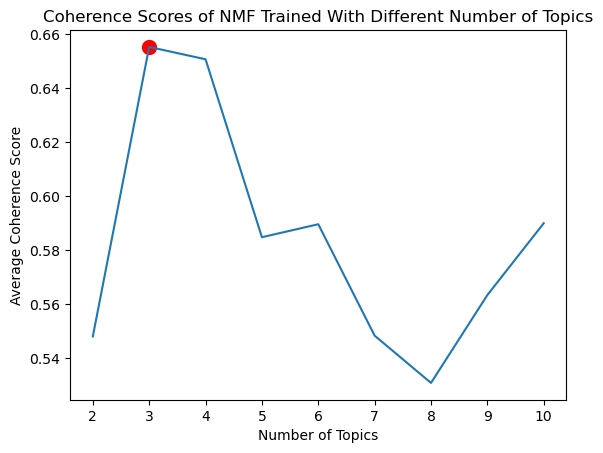

In [44]:
plt.plot(np.arange(2,11), coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence Score')
plt.title('Coherence Scores of NMF Trained With Different Number of Topics')
plt.scatter(best_model.n_components, coherence_scores[best_model.n_components -2], c='red', marker='o', s=100)

In [45]:
#View the top terms for each generated topic for the best NMF Model
for t in range(best_model.n_components):
    print('Topic', str(t+1) + ':', get_terms(best_H, t))

Topic 1: ['united', 'trump', 'states', 'government', 'president', 'politic', 'election', 'donald', 'party', 'republican', 'house', 'washington', 'obama', 'biden', 'say', 'presidential', 'international', 'us', 'military', 'defense', 'federal', 'senate', 'american', 'force', 'democratic', 'state', 'war', 'ukraine', 'department', 'court', 'relation', 'china', 'white', 'official', 'leader', 'we', 'russia', 'jr', 'would', 'economy', 'coronavirus', 'immigration', 'economic', 'news', 'world', 'right', 'country', 'law', 'administration', 'barack']
Topic 2: ['new', 'york', 'city', 'year', 'book', 'day', 'state', 'one', 'jersey', 'time', 'say', 'police', 'make', 'school', 'first', 'ny', 'get', 'people', 'home', 'two', 'life', 'not', 'nyc', 'college', 'connecticut', 'man', 'game', 'like', 'week', 'woman', 'number', 'movie', 'season', 'die', 'work', 'last', 'university', 'show', 'lottery', 'play', 'go', 'take', 'come', 'mayor', 'team', 'know', 'good', 'puzzle', 'manhattan', 'find']
Topic 3: ['marr

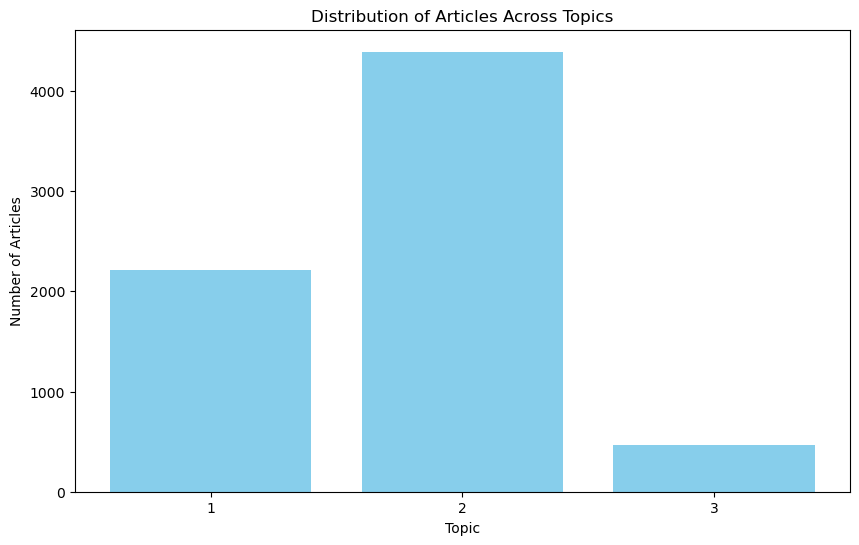

In [46]:
#get the dominant topic for each document
dominant_topics = np.argmax(best_W, axis=1)
#count the articles for each topic
articles_per_topic = np.bincount(dominant_topics, minlength=best_model.n_components)

# visual the distribution
plt.figure(figsize=(10, 6))
topics = range(1, best_model.n_components + 1)
plt.bar(topics, articles_per_topic, color='skyblue')
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.title('Distribution of Articles Across Topics')
plt.xticks(topics)  # Ensure we have a tick for every topic
plt.show()



**Based on this analysis, the 3 topics from the best NMF model can be categorized as:** <p><p>
Lifestyle<p>
Events<p>
Politics<p>

**References**<p>
https://www.kaggle.com/code/rockystats/topic-modelling-using-nmf<p>
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html<p>
https://tedboy.github.io/nlps/generated/generated/gensim.models.CoherenceModel.html<p>